<a href="https://colab.research.google.com/github/zhhhling/RiskLimitingDispatch/blob/main/v4_neural_policy_118bus_continue_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Aug 25 15:58:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## utils.py

In [4]:
import os, time
import cvxpy as cp
import random
from numpy import savetxt
import argparse
import json
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable

In [5]:
def create_dir(PATH):
    isExist = os.path.exists(PATH)

    if not isExist:
        # Create a new directory if it does not exist 
        os.makedirs(PATH)
        print("The new directory is created!")

In [6]:
# Evaluate using vector distance
def measure_relative_distance(v1, v2):
    '''
        Note that v1 is the benchmark.
        Norm is calculated along dimension/axis 1
        and average is calculated along dimension/axis 0
    '''
    if len(v1.shape)==1 and len(v2.shape)==1:
        distance = np.abs(v1-v2)/np.abs(v1)

    if len(v1.shape)==2 and len(v2.shape)==2:
        distance = np.linalg.norm(v1-v2, axis=1)/np.linalg.norm(v1, axis=1)

    return np.mean(distance)

In [7]:
def identify_unique_lines(connections):
    all_lines = {}
    count = 0
    for line in connections:
        all_lines[count] = line
        count+=1

    # This code snippet only finds out the repeated lines with exactly the same order of nodes,
    # but not deal with that [i,j] and [j,i] are also repeated lines
    # By checking connections, there is no repeated lines like [i,j] and [j,i]
    unique_lines = {}
    for k, val in all_lines.items():
        if val not in unique_lines.values():
            unique_lines[k]=val
    print('unique_lines length:', len(unique_lines))

    repeated_lines = [[42, 49],[49, 54],[56, 59],[49, 66],[77, 80],[89, 90],[89, 92]]
    # For example, [42, 49] appears twice
    set1 = {}
    set2 = {}
    for k, val in all_lines.items():
        if val in repeated_lines and k in unique_lines:
            set1[val[0], val[1]] = k # Record the repeated lines when they first appear
        if val in repeated_lines and k not in unique_lines:
            set2[val[0], val[1]] = k # Record the repeated lines when they appear more than once

    # print('set1:', len(set1))
    # print('set2:', len(set2))

    return unique_lines, set1, set2

In [8]:
def get_Y():
    N = num_buses
    Y = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i==j : 
                Y[i,j] = sum(B[i,:])
            else: 
                Y[i,j] = -B[i,j]

    return Y[:,1:]

def get_A():
    N = num_buses
    L = num_lines 
    A = np.zeros((L, N))

    for i, line in enumerate(connections):
        row = line[0]-1
        col = line[1]-1
        A[i, row] = B[row,col]
        A[i, col] = -B[row,col]

    return A[:,1:]


In [9]:
std = 0.25

## models.py



```
ReLUNet
tanhNet
LReLUNet
```



In [10]:
class ActionNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(ActionNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, H)
        # self.linear4 = torch.nn.Linear(H, H)
        self.linear4 = torch.nn.Linear(H, D_out)

        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.5)


    def forward(self, input):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # x = torch.tanh(self.linear1(input))
        # x = torch.tanh(self.linear2(x))
        # x = torch.tanh(self.linear3(x))
        # x = torch.tanh(self.linear4(x))
        # y_pred = torch.tanh(self.linear5(x))

        x = F.relu(self.linear1(input))
        x = self.dropout(x)
        x = F.relu(self.linear2(x))
        x = self.dropout(x)
        x = F.relu(self.linear3(x))
        x = self.dropout(x)
        # x = F.relu(self.linear4(x))
        # x = self.dropout(x)
        y_pred = F.relu(self.linear4(x))


        return y_pred

In [11]:
class RewardNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(RewardNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, H)
        # self.linear4 = torch.nn.Linear(H, H)
        self.linear4 = torch.nn.Linear(H, D_out)

        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.25)

    def forward(self, input):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # x = torch.tanh(self.linear1(input))
        # x = torch.tanh(self.linear2(x))
        # x = torch.tanh(self.linear3(x))
        # x = torch.tanh(self.linear4(x))
        # y_pred = torch.tanh(self.linear5(x))

        x = F.relu(self.linear1(input))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        y_pred = torch.tanh(self.linear4(x))

        # x = self.linear1(input)
        # x = self.linear2(x)
        # x = self.linear3(x)
        # y_pred = torch.tanh(self.linear4(x))

        return y_pred

In [12]:
class TrainDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
	# must override two of the subclass functions:
    def __len__(self):
        # return len(self.samples)
        return self.samples.shape[0]

    def __getitem__(self, idx):
        # return self.samples[idx]
        return self.samples[idx,:]

## gauge.py


In [13]:
def gauge_function(V, G, H):
    """
    The gauge function of the vector z w.r.t. the set P
    is given by the following code.

    V can be batched, for example, r-dimensional and batch size of K, then shape(V) = (r, K)
    Note that the second dimension is the batch.

    P is defined by {v: G@v <= Hj} = {v: g_i^T@v <= Hj_i, i = 1, ..., q}
    shape(G) = (q, r), shape(Hj) = (q, 1), shape(H) = (q, K)
    P must contain the origin in its interior.
    
    """
    # return torch.max(G@V/H,dim = 0).values # shape(output) = (1, K)

    # torch.div() for element-wide division
    return torch.max(torch.div(G@V, H),dim = 0).values # shape(output) = (1, K)

def gauge_map(Z, G, H):
    """
    For any Z \belongsto B_infinity, the gauge map from B_infinity to the set P
    defined by {v: G@v <= h} is given by the following code.
    
    Z can be batched, for example, r-dimensional and batch size of K, then shape(V) = (r, K)
    Note that the second dimension is the batch.

    P is defined by {v: G@v <= Hj} = {v: g_i^T@v <= Hj_i, i = 1, ..., q}
    shape(G) = (q, r), shape(Hj) = (q, 1), shape(H) = (q, K)
    P must contain the origin in its interior.
    """

    gamma_dest = gauge_function(Z, G, H)# shape = (1, K)
    # print('gamma_dest:', gamma_dest)
    gamma_start = torch.linalg.norm(Z, ord = np.inf, dim=0) # shape(1, K)

    scaling_mat = torch.diag(gamma_start/gamma_dest) # shape = (K, K)

    return Z@scaling_mat # shape = (r, K), this is the new point in P

## Paths are defined here

In [14]:
params_path = './gdrive/MyDrive/Inbox/rld_118bus/neural_policy/params/'

saved_path = './gdrive/MyDrive/Inbox/rld_118bus/neural_policy/results4/'
isExist = os.path.exists(saved_path)

if not isExist:
    # Create a new directory if it does not exist 
    os.makedirs(saved_path)

data_path = './gdrive/MyDrive/Inbox/rld_118bus/neural_policy/data/'
isExist = os.path.exists(data_path)

if not isExist:
    # Create a new directory if it does not exist 
    os.makedirs(data_path)

## Import 118bus system (118bus.py)
## Define paths



```
pretrained path
saved path
```



In [15]:
bus_data_fname = '118bus_BusData.csv'
gen_data_fname = '118bus_GenData.csv'

branch_data_fname = '118bus_BranchData.csv'
cost_data_fname = '118bus_CostData.csv'

bus_data_df = pd.read_csv(params_path+bus_data_fname,header=None)
gen_data_df = pd.read_csv(params_path+gen_data_fname,header=None)
branch_data_df = pd.read_csv(params_path+branch_data_fname,header=None)
cost_data_df = pd.read_csv(params_path+cost_data_fname,header=None)

# display(bus_data_df)
# display(gen_data_df)
# display(branch_data_df)
# display(cost_data_df)

num_buses = bus_data_df.shape[0]
num_lines = branch_data_df.shape[0]
num_gens = gen_data_df.shape[0]

print('num_buses:', num_buses)
print('num_lines:', num_lines)
print('num_gens:', num_gens)

bus_data = bus_data_df.to_numpy()
gen_data = gen_data_df.to_numpy()
branch_data = branch_data_df.to_numpy()
cost_data = cost_data_df.to_numpy()

x = branch_data[:,3]
# print('x:')
# display(pd.DataFrame(x))
print('max of x:', max(x))
print('min of x:', min(x))


b = 1/x
# print('b:')
Z0 = 10
b = b/Z0
# display(pd.DataFrame(b))
print('max of b:', max(b))
print('min of b:', min(b))

connections = []
branches = branch_data[:,:2]
for i in range(branches.shape[0]):
		connections.append([int(branches[i,0]),int(branches[i,1])])
print('len of connections:', len(connections))

unique_lines, set1, set2 = identify_unique_lines(connections)
# print('set1:', set1)
# print('set2:', set2)

B = np.zeros((num_buses, num_buses))
# for i, line in enumerate(connections):
for k, line in unique_lines.items():
    row = line[0]-1
    col = line[1]-1
    B[row, col] = b[k]
    B[col, row] = b[k]

# display(pd.DataFrame(B).head())

Yrr = get_Y()
Arr = get_A()

N = num_buses
L = num_lines 

G = np.block([
              [Arr],
              [-Arr],
              [np.eye(N-1)],
              [-np.eye(N-1)]
])
print('G shape:', G.shape)

ymax = 2
ymin = 0
Fmax = 2

PD = bus_data[:,2]/20
print('PD:')
display(pd.DataFrame(PD))
# PD_data = PD.to_numpy()
PD_data = PD
print('Total PD:', sum(PD))

nominal_PD_data = PD_data.reshape(1,-1)



num_buses: 118
num_lines: 186
num_gens: 54
max of x: 0.411
min of x: 0.004
max of b: 25.0
min of b: 0.24330900243309003
len of connections: 186
unique_lines length: 179
G shape: (606, 117)
PD:


,0
0,2.55
1,1.00
2,1.95
3,1.95
4,0.00
...,...
113,0.40
114,1.10
115,9.20
116,1.00


Total PD: 212.10000000000005


## Load cost coefficients

In [16]:
def load_cost_coeff():    
    quad_cost_coeff = np.load(params_path+'quad_cost_coeff.npy')
    linear_cost_coeff = np.load(params_path+'linear_cost_coeff.npy')
    da_cost_coeff = np.load(params_path+'da_cost_coeff.npy')

    return quad_cost_coeff, linear_cost_coeff, da_cost_coeff

In [17]:
quad_cost_coeff, linear_cost_coeff, da_cost_coeff = load_cost_coeff() 

quad_cost_Coeff = np.diag(quad_cost_coeff)
linear_cost_Coeff = linear_cost_coeff.reshape(-1, 1)

da_cost_Coeff = da_cost_coeff.reshape(-1,1)

print('quad_cost_Coeff shape:', quad_cost_Coeff.shape)
print('linear_cost_Coeff shape:', linear_cost_Coeff.shape)
print('da_cost_Coeff shape:', da_cost_Coeff.shape)


quad_cost_Coeff shape: (118, 118)
linear_cost_Coeff shape: (118, 1)
da_cost_Coeff shape: (118, 1)


## gauge mapping

In [18]:
G = np.block([
              [Arr],
              [-Arr],
              [np.eye(N-1)],
              [-np.eye(N-1)]
])
print('G shape:', G.shape)

G shape: (606, 117)


## Get train dataset prepared

In [19]:
# train_dataset = np.concatenate([a_input, a_target, q_input, lambda_data, nu_data], axis=-1)
DataFlag = False
if DataFlag == True:

    num_points = 50000
    forecasts = nominal_PD_data.reshape(1,-1)

    # Pattern 2: folowing the trend of nominal load
    ratio = 0.05
    lb = np.clip((1-ratio)*forecasts, a_min=0., a_max=None)
    ub = (1+ratio)*forecasts
    # ub = np.maximum( (1+ratio)*forecasts, 0.05*np.ones_like(forecasts)) # if the nominal load is zero, then sample from [0, 0.1]

    train_dataset = np.random.uniform(lb, ub, (num_points, N))
    test_dataset = np.random.uniform(lb, ub, (100, N))

    np.save(data_path+'train_set_point05.npy', train_dataset)
    np.save(data_path+'test_set_point05.npy', test_dataset)

else:
    train_dataset = np.load(data_path+'train_set_point05.npy')
    test_dataset = np.load(data_path+'test_set_point05.npy')

TrainSet = TrainDataset(train_dataset)
TestSet = TrainDataset(test_dataset)

## Train action and reward nets together

In [20]:
def train(dataset, num_epochs, num_sce, batch_size, yplot = 'plain'):

    def plot_train_loss(train_hist, epoch):
        print('len:', len(train_hist['train_losses']))

        fig = plt.figure(figsize=(10,10))
        plt.ticklabel_format(style='plain', scilimits=(-3, 3), useOffset=False)
        ax = fig.add_subplot(1, 1, 1)
        if yplot == 'log10':
            ax.plot(range(len(train_hist['train_losses'])), np.log10(train_hist['train_losses']), label='train loss')
            ax.set_ylabel('log10(train loss)',fontsize=20)
        elif yplot == 'plain':
            ax.plot(range(len(train_hist['train_losses'])), train_hist['train_losses'], label='train loss')
            ax.set_ylabel('train loss',fontsize=20)
        ax.set_xlabel('training epochs',fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.savefig(saved_path+str(epoch)+'train_losses.png')


    # Set learning rates
    lr = 0.001

    # Build models or load models
    # action_net, reward_net = load_saved_models()
    action_net = ActionNet(N, 125, N)
    reward_net = RewardNet(N, 100, N-1)
    

    # Configure optimizers
    action_optim = optim.Adam(action_net.parameters(), lr=lr, betas=(0.5, 0.999))
    reward_optim = optim.Adam(reward_net.parameters(), lr=lr, betas=(0.5, 0.999))


    # Constant Parameters
    G_ts = torch.tensor(G).float()
    Yrr_ts = torch.tensor(Yrr).float()
    Arr_ts = torch.tensor(Arr).float()
    # C1_ts = torch.tensor(quad_cost_Coeff).float()
    C2_ts = torch.tensor(linear_cost_Coeff).float()
    da_cost_ts = torch.tensor(da_cost_Coeff).float()

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    train_hist = {}
    train_hist['train_losses'] = []
    train_hist['per_epoch_time'] = []
    train_hist['total_time'] = []
    num_iter = 0

    print('Training starts!')
    start_time = time.time()

    for epoch in range(num_epochs):
        train_losses = []
        epoch_start_time = time.time()

        for batch in train_loader:

             ## zero grad
            action_net.zero_grad()
            reward_net.zero_grad()

            ## get a batch of data
            input = batch.float()
            x = action_net(input)
            net_input = input-x
            
            Q_pred = 0.
            for m in range(num_sce):
                q_input = net_input + std*torch.randn_like(net_input)
            
                pred = reward_net(q_input)

                h_batch = torch.cat([
                                    Fmax*torch.ones(L, batch_size),
                                    Fmax*torch.ones(L, batch_size),
                                    np.pi*torch.ones(N-1, batch_size),
                                    np.pi*torch.ones(N-1, batch_size)
                                    ],dim=0)

                h_batch_ts = torch.tensor(h_batch).float()
                
                ctr_ts = torch.zeros((num_buses-1, batch_size))
                assert torch.max(G_ts@ctr_ts - h_batch_ts)< 0.0, "Caution: v0 is not a feasible point."

                # Use ctr_ts to shift the feasible set Gv<=H
                h_shift = h_batch_ts - G_ts@ctr_ts
                assert torch.min(h_shift) > 0.0, "Caution: origin is not an interior point"

                # Use gauge mapping to transform output to feas_output
                feas_pred = gauge_map(pred.T, G_ts, h_shift) + ctr_ts

                # Construct cost function
                y = F.relu(Yrr_ts@feas_pred + net_input.T) # (N, batch_size)
                # quad_cost = torch.diagonal(y.T@C1_ts@y)
                linear_cost = y.T@C2_ts
                # rt_cost += quad_cost + linear_cost.flatten()
                Q_pred += linear_cost.flatten()

            Q_pred = Q_pred/num_sce
            da_cost = x@da_cost_ts
            total_cost = Q_pred + da_cost.flatten()

            train_loss = torch.mean(total_cost) 

            train_loss.backward(retain_graph=True)
            action_optim.step()
            reward_optim.step()

            train_losses.append(train_loss.item())


            num_iter += 1

            if num_iter % 10000 == 0:
                print('[%d/%d], loss: %.5f' % ((epoch + 1), 
                    (num_iter + 1), 
                    torch.FloatTensor(train_losses).mean().item()))
                
        epoch_end_time = time.time()
        per_epoch_time = epoch_end_time - epoch_start_time

        loss_value = torch.mean(torch.FloatTensor(train_losses)).item()

        train_hist['train_losses'].append(round(loss_value, 4))
        train_hist['per_epoch_time'].append(per_epoch_time)
                
        if epoch > 0 :
            if epoch % 200 == 0 or epoch == num_epochs-1:

                torch.save(action_net.state_dict(), saved_path+'trained_action_net.pt')

                torch.save(reward_net.state_dict(), saved_path+'trained_reward_net.pt')

                plot_train_loss(train_hist, epoch)
                
    end_time = time.time()
    total_time = end_time - start_time
    train_hist['total_time'].append(total_time)

    print("Avg per epoch time: %.2f, total %d epochs time: %.2f" % \
        (torch.mean(torch.FloatTensor(train_hist['per_epoch_time'])), num_epochs, total_time))
    print("Training finish!")

    print(len(train_hist['train_losses']))

    # End training loop
    return action_net, reward_net


In [21]:
def load_saved_models():
    action_net = ActionNet(N, 125, N)
    action_net.load_state_dict(torch.load(saved_path+'trained_action_net.pt'))
    action_net.eval()

    reward_net = RewardNet(N, 100, N-1)
    reward_net.load_state_dict(torch.load(saved_path+'trained_reward_net.pt'))
    reward_net.eval()

    action_net.train(False)
    reward_net.train(False)

    return action_net, reward_net

In [22]:
saved_path

'./gdrive/MyDrive/Inbox/rld_118bus/neural_policy/results4/'

In [23]:
TrainFlag = False
if TrainFlag:
    # random.seed(0)
    trained_action_net, trained_reward_net = train(TrainSet, num_epochs=600, 
                                               num_sce=50, batch_size=100, 
                                               yplot = 'plain')
    
else:
    trained_action_net, trained_reward_net = load_saved_models()

## Compare performance of trained action net against benchmark


In [24]:
def test_neural_policy(dataset, num_sce):

    action_net, reward_net = load_saved_models()

    # Constant Parameters
    G_ts = torch.tensor(G).float()
    Yrr_ts = torch.tensor(Yrr).float()
    Arr_ts = torch.tensor(Arr).float()
    # C1_ts = torch.tensor(quad_cost_Coeff).float()
    C2_ts = torch.tensor(linear_cost_Coeff).float()
    da_cost_ts = torch.tensor(da_cost_Coeff).float()

    batch_size = dataset.shape[0]

    with torch.no_grad():

        input = torch.tensor(dataset).float()

        x = action_net(input)
        
        net_input = input-x
            
        Q_pred = 0.
        y_pred = torch.zeros_like(x)
        for m in range(num_sce):
            q_input = net_input + std*torch.randn_like(net_input)
        
            pred = reward_net(q_input)

            h_batch = torch.cat([
                                Fmax*torch.ones(L, batch_size),
                                Fmax*torch.ones(L, batch_size),
                                np.pi*torch.ones(N-1, batch_size),
                                np.pi*torch.ones(N-1, batch_size)
                                ],dim=0)

            h_batch_ts = torch.tensor(h_batch).float()
            
            ctr_ts = torch.zeros((num_buses-1, batch_size))
            assert torch.max(G_ts@ctr_ts - h_batch_ts)< 0.0, "Caution: v0 is not a feasible point."

            # Use ctr_ts to shift the feasible set Gv<=H
            h_shift = h_batch_ts - G_ts@ctr_ts
            assert torch.min(h_shift) > 0.0, "Caution: origin is not an interior point"

            # Use gauge mapping to transform output to feas_output
            feas_pred = gauge_map(pred.T, G_ts, h_shift) + ctr_ts

            # Construct cost function
            y = F.relu(Yrr_ts@feas_pred + net_input.T) # (N, batch_size)
            # quad_cost = torch.diagonal(y.T@C1_ts@y)
            linear_cost = y.T@C2_ts
            # rt_cost += quad_cost + linear_cost.flatten()
            Q_pred += linear_cost.flatten()

            y_pred+= y.T

        Q_pred = Q_pred/num_sce
        da_cost = x@da_cost_ts
        total_cost = Q_pred + da_cost.flatten()

        y_pred = y_pred/num_sce

        x_val = x.detach().numpy()
        total_cost_val = total_cost.detach().numpy().reshape(-1,1)
        Q_val = Q_pred.detach().numpy().reshape(-1,1)

        y_val = y_pred.detach().numpy()

        return x_val, total_cost_val, Q_val, y_val


In [25]:
x_pred, J_pred, Q_pred, y_pred = test_neural_policy(test_dataset, num_sce=100)
print('x_pred:', x_pred.shape)
print('J_pred:', J_pred.shape)
print('Q_pred:', Q_pred.shape)
print('y_pred:', y_pred.shape)

x_pred: (100, 118)
J_pred: (100, 1)
Q_pred: (100, 1)
y_pred: (100, 118)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


### Note that you have to feed x_pred into CVXPY for comparison because you only care about x

In [26]:
def base_solver(net_input, num_sce):

    M = num_sce

    v = cp.Variable((N-1,M))
    y = cp.Variable((N, M))

    constraints_list = []

    ## for each scenario, there will be dual variables lambda_m, 
    ## mu_up_m, mu_lw_m of size (N, 1), (L, 1), (L, 1)
    for m in range(M):
        q_input = net_input + std*np.random.randn(N, 1) # of same size as x
        constraints_list.append( y[:,m:m+1] >= Yrr@v[:,m:m+1] + q_input )
        
    constraints_list.append( Arr@v <= Fmax*np.ones((num_lines, M)))
    constraints_list.append( Arr@v >= -Fmax*np.ones((num_lines, M)))

    constraints_list.append( v<=np.pi)
    constraints_list.append( v>=-np.pi)
    constraints_list.append( y>=0)

    Q_vals = []
    for m in range(M):

        # total_cost += cp.quad_form(y[:,m:m+1], quad_cost_Coeff) + y[:,m:m+1].T@linear_cost_Coeff
        Q_vals.append(y[:,m:m+1].T@linear_cost_Coeff)

    Q_pred = cp.sum(Q_vals)/M

    prob = cp.Problem(cp.Minimize( Q_pred ), constraints_list)

    prob.solve(verbose = False, solver = cp.ECOS) ## Works!   

    return prob.value, np.sum(y.value, axis=1)/M


def benchmark_solver(test_set, x_pred, num_sce):

    net_load = test_set - x_pred

    num_points = net_load.shape[0]

    Q_pred = []
    y_pred = []
    for i in range(num_points):
        net_input = net_load[i,:].reshape(-1,1)

        Q_value, y_value = base_solver(net_input, num_sce)

        Q_pred.append(Q_value)
        y_pred.append(y_value.flatten())

    Q_pred = np.array(Q_pred).reshape(-1,1)
    y_pred = np.array(y_pred)

    # total_cost_pred = Q_pred.reshape(-1, 1)+x_pred@da_cost_Coeff
    total_cost_pred = x_pred@da_cost_Coeff + Q_pred
    print('total_cost_pred:', total_cost_pred.shape)

    return total_cost_pred, Q_pred, y_pred

In [27]:
total_cost_pred, Q_pred, y_pred = benchmark_solver(test_dataset, x_pred, 100)
print('total_cost_pred:', total_cost_pred.shape)

total_cost_pred: (100, 1)
total_cost_pred: (100, 1)


In [28]:
np.save(saved_path+'x_pred.npy', x_pred)
np.save(saved_path+'total_cost_pred.npy', total_cost_pred)
np.save(saved_path+'Q_pred.npy', Q_pred)
np.save(saved_path+'y_pred.npy', y_pred)

## Use CVXPY to solve this two-stage stochastic program as benchmark

In [29]:
def solve_dispatch_scenarios(forecast, num_sce):
    '''
    scenarios should be of size (N, M)

    '''
    M = num_sce

    x = cp.Variable((N, 1))
    v = cp.Variable((N-1,M))
    y = cp.Variable((N, M))

    constraints_list = []

    ## for each scenario, there will be dual variables lambda_m, 
    ## mu_up_m, mu_lw_m of size (N, 1), (L, 1), (L, 1)
    net_input = forecast - x
    for m in range(M):
        q_input = net_input + std*np.random.randn(N, 1) # of same size as x
        constraints_list.append( y[:,m:m+1] >= Yrr@v[:,m:m+1] + q_input )
        
    constraints_list.append( Arr@v <= Fmax*np.ones((num_lines, M)))
    constraints_list.append( Arr@v >= -Fmax*np.ones((num_lines, M)))

    constraints_list.append( v<=np.pi)
    constraints_list.append( v>=-np.pi)
    constraints_list.append( x>=0)
    constraints_list.append( y>=0)

    Q_vals = []
    for m in range(M):

        # total_cost += cp.quad_form(y[:,m:m+1], quad_cost_Coeff) + y[:,m:m+1].T@linear_cost_Coeff
        Q_vals.append(y[:,m:m+1].T@linear_cost_Coeff)

    Q_pred = cp.sum(Q_vals)/M
    prob = cp.Problem(cp.Minimize( da_cost_Coeff.T@x + Q_pred ), constraints_list)

    # result =  prob.solve()
    # prob.solve(verbose = True, solver = cp.ECOS) ## Works!   
    prob.solve(verbose = False, solver = cp.ECOS) ## Works!   

    return x.value.T, prob.value, Q_pred.value, np.sum(y.value, axis=1)/M


def solve_dispatch(forecasts, num_sce):
    '''
        Provided a forecast and yield the value of x.
        In order to calculate x, also need to provide a set of future/real-time
        scenarios.
        Collect these future/real-time scenarios into experiences.
        experiences = [forecast(M copies), disrupt(M size), x(M copies), dcopf primal solution, dual solution]


    '''
    num_points = forecasts.shape[0]

    x_vals = []
    total_cost_vals = []
    Q_vals = []
    y_vals = []


    for it in range(num_points):

        forecast = forecasts[it,:].reshape(-1,1)

        ## provide this set of scenarios and decide the value of x
        x_value, prob_value, Q_value, y_value = solve_dispatch_scenarios(forecast, num_sce)
    
        x_vals.append(x_value.flatten())
        total_cost_vals.append(prob_value)
        Q_vals.append(Q_value)

        y_vals.append(y_value.flatten())

        # print("--- %s minutes ---" % ((time.time() - start_time)/60))

    x_vals = np.array(x_vals)
    total_cost_vals = np.array(total_cost_vals).reshape(-1,1)
    Q_vals = np.array(Q_vals).reshape(-1,1)

    y_vals = np.array(y_vals)

    return x_vals, total_cost_vals, Q_vals, y_vals


In [30]:
x_labels, total_cost_labels, Q_labels, y_labels = solve_dispatch(test_dataset, num_sce=100)

print('x_benchmark:', x_labels.shape)
print('total_cost_benchmark:', total_cost_labels.shape)
print('Q_benchmark:', Q_labels.shape)
print('y_benchmark:', y_labels.shape)

x_benchmark: (100, 118)
total_cost_benchmark: (100, 1)
Q_benchmark: (100, 1)
y_benchmark: (100, 118)


In [31]:
np.save(saved_path+'x_labels.npy', x_labels)
np.save(saved_path+'total_cost_labels.npy', total_cost_labels)
np.save(saved_path+'Q_labels.npy', Q_labels)
np.save(saved_path+'y_labels.npy', y_labels)

## Compare proposed algorithm against benchmark

### Calculate relative distance between vectors for x, J and Q

In [32]:
x_dist = measure_relative_distance(x_labels, x_pred)
total_cost_dist = measure_relative_distance(total_cost_labels, total_cost_pred)
Q_dist = measure_relative_distance(Q_labels, Q_pred)

print('Averaged relative error in x is %.2f%%' % (x_dist*100))
print('Averaged relative error in total_cost is %.2f%%' % (total_cost_dist*100))
print('Averaged relative error in Q is %.2f%%' % (Q_dist*100))

Averaged relative error in x is 13.68%
Averaged relative error in total_cost is 1.10%
Averaged relative error in Q is 15.32%


### Plot

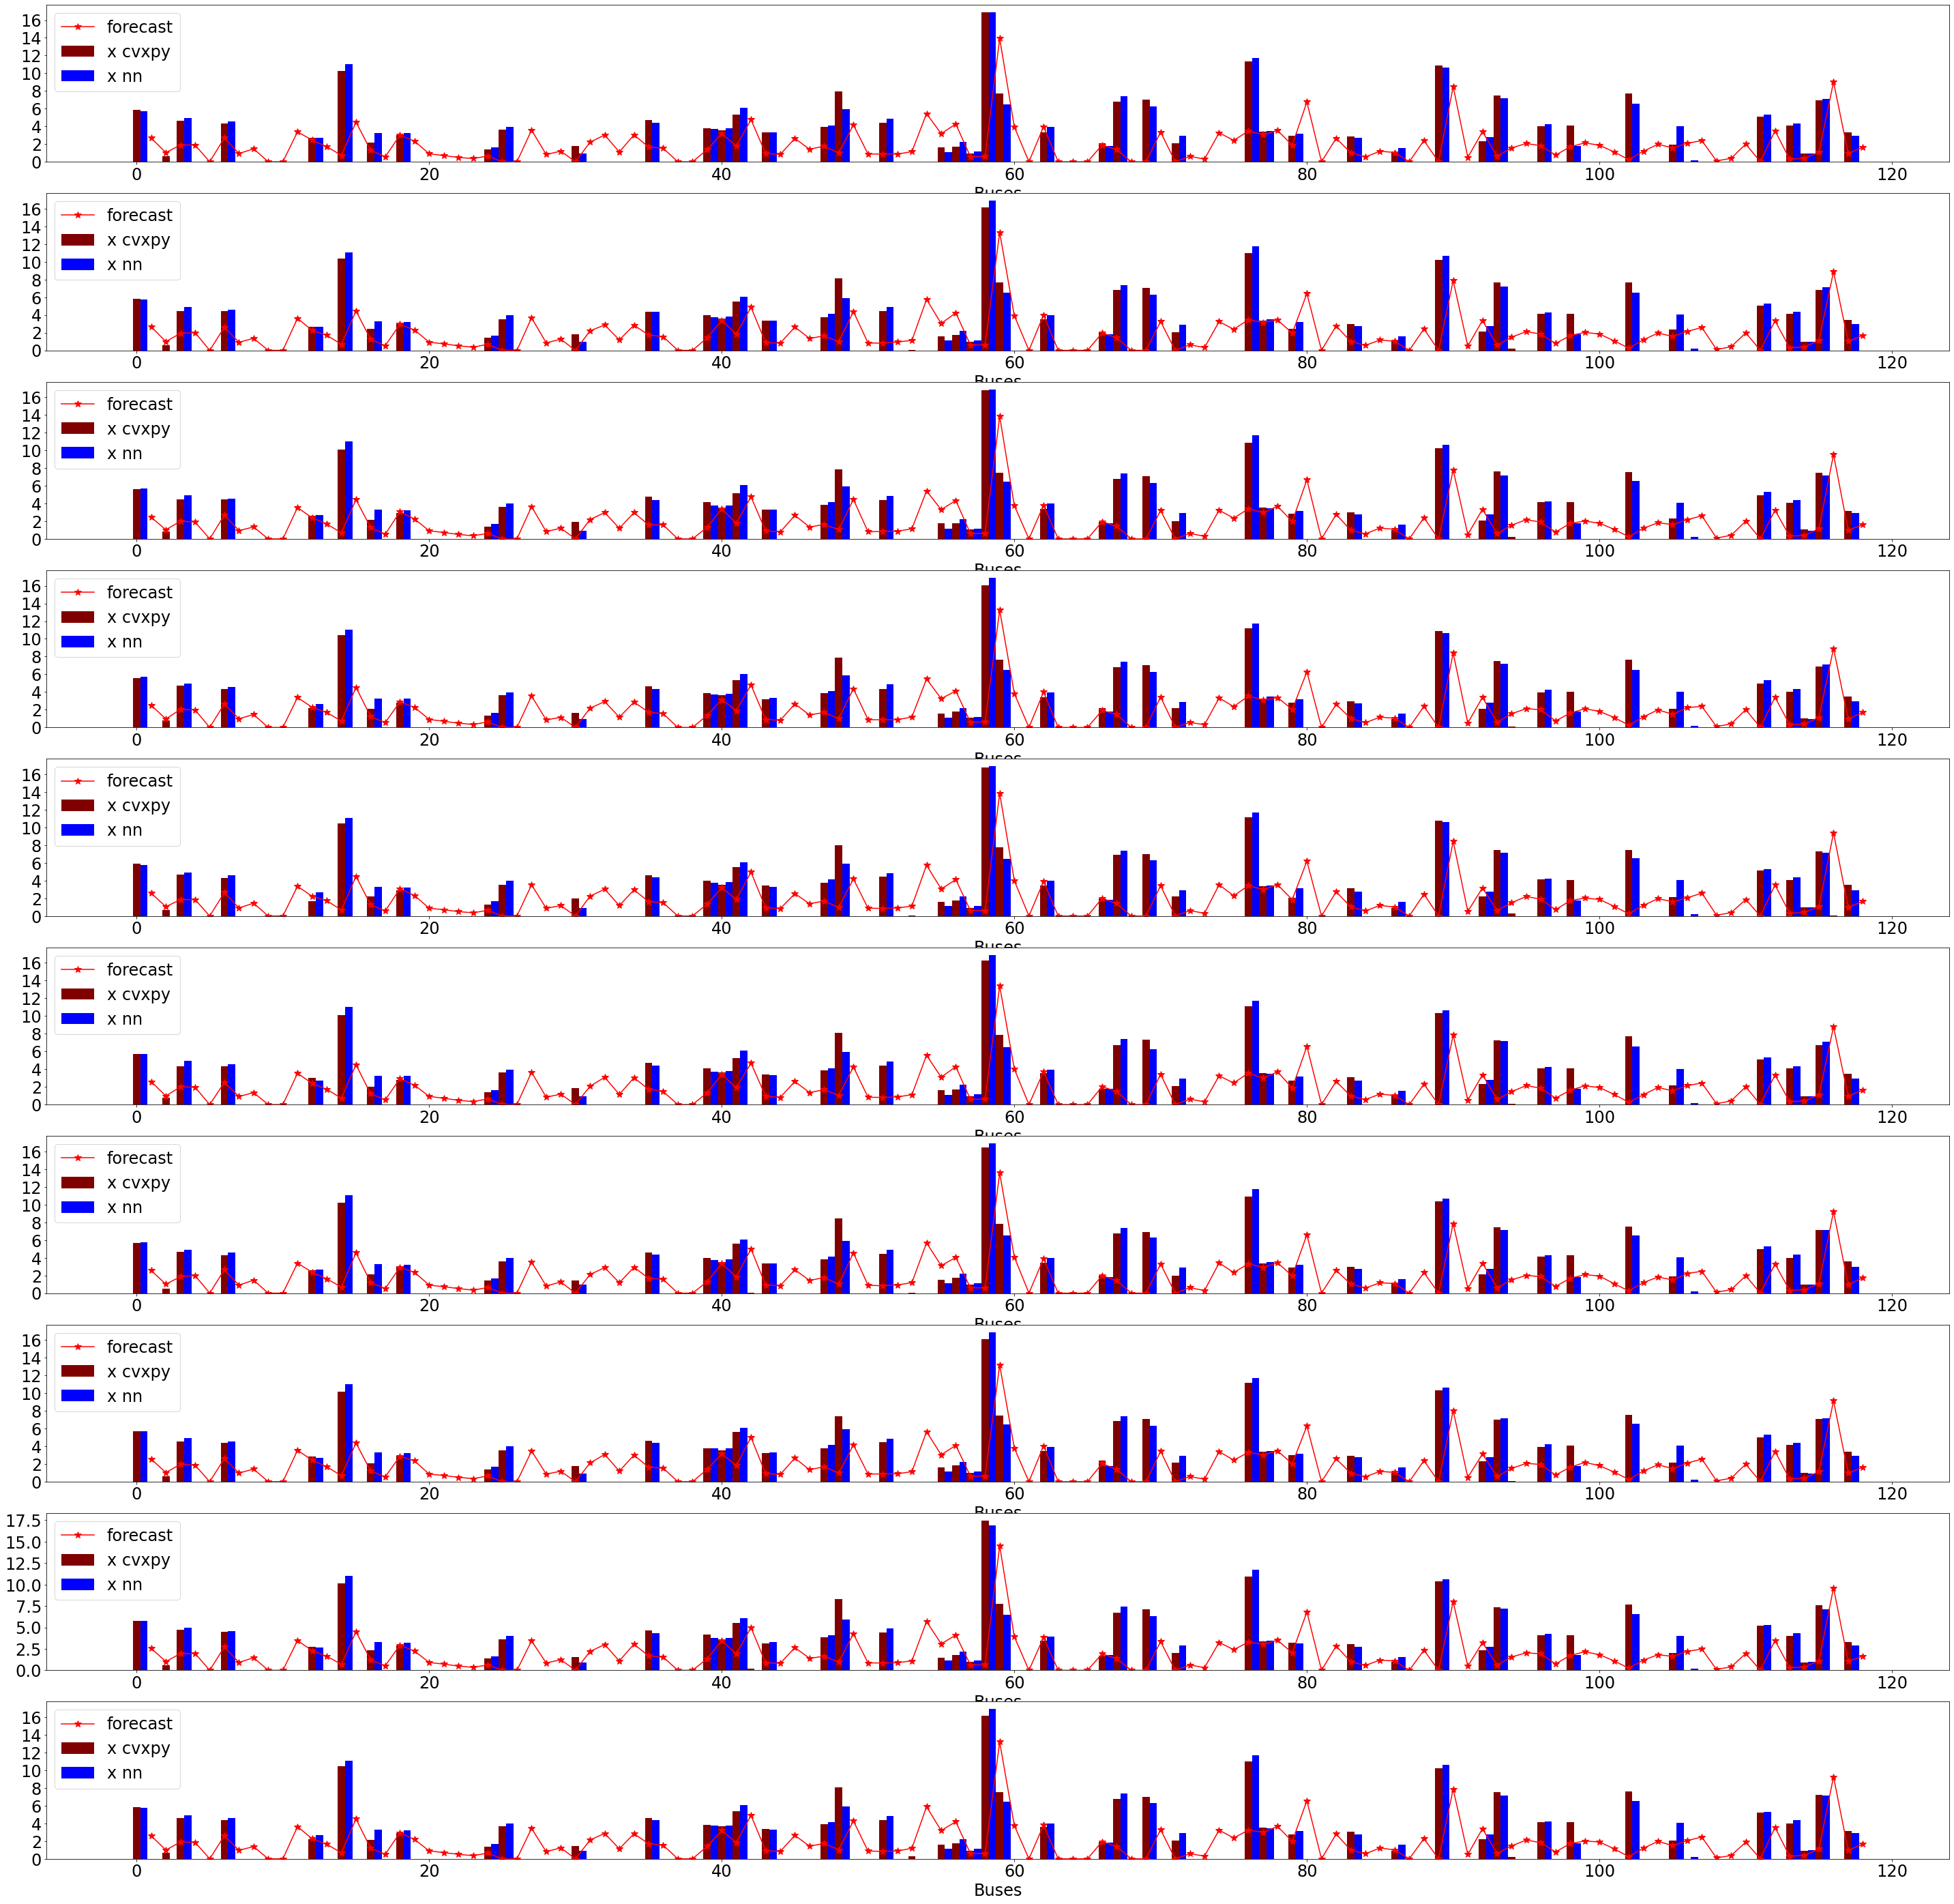

In [33]:
fig = plt.figure(figsize=(50,50))

for i in range(1, 11, 1):
    plt.subplot(10, 1, i)
    Xrange = np.array(range(N))
    plt.plot(range(1, N+1), test_dataset[i+80,:], 'r-*', markersize=10, label='forecast')
    plt.bar(Xrange, x_labels[i+80,:], width = 0.5, color ='maroon',label='x cvxpy')
    plt.bar(Xrange+0.5, x_pred[i+80,:], width = 0.5, color ='blue',label='x nn')

    plt.legend(fontsize=24)
    plt.xlabel('Buses', fontsize=24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)

plt.show()


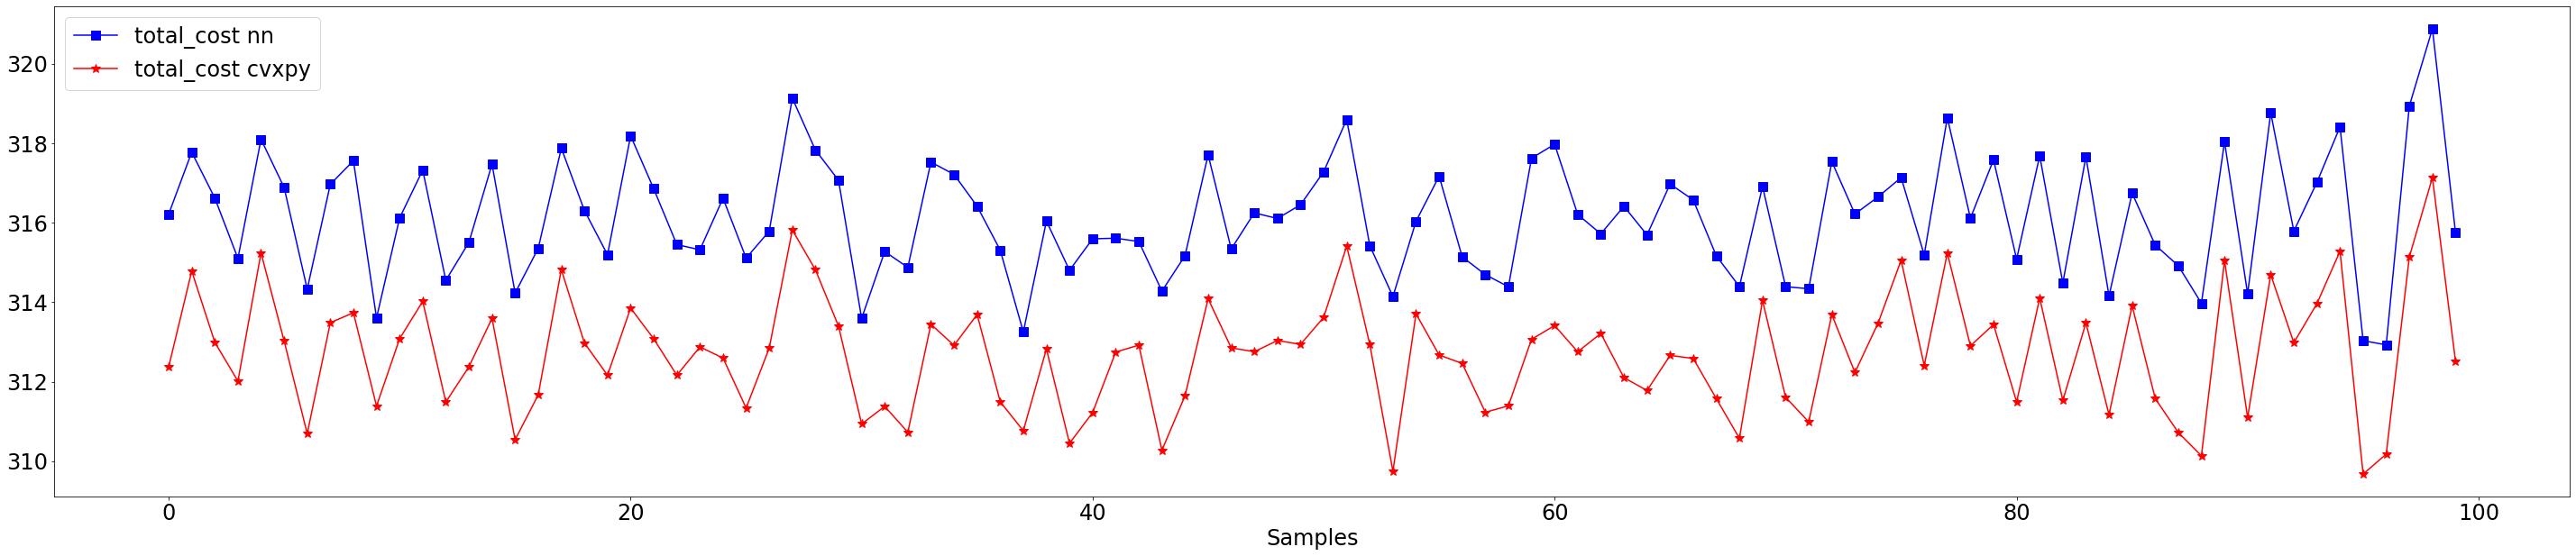

In [34]:
fig = plt.figure(figsize=(50,10))
plt.plot(range(100), total_cost_pred.flatten(), 'b-s', markersize=10, label='total_cost nn')
plt.plot(range(100), total_cost_labels.flatten(), 'r-*', markersize=10, label='total_cost cvxpy')

plt.legend(fontsize=24)
plt.xlabel('Samples', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.show()